# Predicting Ames Housing Prices

## Executive Summary

This project was tied to an internal Kaggle competition to predict housing prices for Ames, Iowa, given a dataset from the Ames, Iowa Assessor's Office containing information on houses sold between 2006-2010 ([data dictionary and information can be found here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).) Our challenge was to build a linear regression model that would most accurately predict housing prices (given 80 housing features to select from and model with.) At the closing of the competition, the 'best' model I built predicted housing prices with an RMSE of 21,167 on the 30% of the data (7th place on the leaderboard), but was drastically overfit on the remaining 70% of the data and came in at 81/90 with an RMSE of 41,187. 

Key decisions I made during the modeling process:

**1. Filled null values with 0:** I didn't drop columns with significant null values. When I examined the columns with nulls, I found most of them weren't really reflecting missing information but were input as 'NA' because a house didn't have that feature (ex. pool). I didn't feel it was necessary to treat categorical and numerical columns differently when filling 'null' cells with 0 because I ultimately dummied out the categorical data anyway.

**2. Dropping Outliers:** the data dictionary provided a clue on outliers in the data, and mapping sale price against above grade living area I was able to identify two that were in our dataset. According to the data dictionary, it's likely the outliers in our data were from unusual partial sales of large properties. I chose to remove the outliers to make the model better predict the majority of housing prices, and this did improve my model's scores. 

**3. Mapping Numeric Values to Ordinal Values:** Several of the object-type columns were rating the quality of different features of a house (ex. kitchen, fireplace) with string values instead of numeric values. I thought the model would be more powerful if these were numerical values instead of categorical (dummy) variables, so I created dictionaries of numeric values and mapped those to the columns. I went farther than columns with just the 'Poor' to 'Excellent' ratings and mapped numeric values to any feature that seemed to have a clear 'best' to 'worst' value (ex. Basement Finish). I ended up mapping numeric values to 19 features.

**4. Feature Selection:** for my model, the only features I dropped completely were ID and PID. There were other features that I modified (ex. changed year built to decade and made this categorical) but in general I didn't drop features from the model. I converted categorical variables to dummy variables, used polynomial features on all features, and scaled them.

**5. Normalizing Features:** plotting the distribution of sale prices, there is a strong positive skew that was going to impact the skew of my residuals. I dealt with this by taking the natural log of saleprice (and reversing the log with np.exp after making predictions to convert them back into sale prices at the end.) 

**6. Using Lasso/Elastic Net Regression:** with polynomial features for all features, I needed a strong regularizer to cut down noise and Lasso was more effective than Ridge (best average cross-validated R^2 scores with Lasso were 0.924 on the train data and 0.918 on the test data.) I experimented with Elastic Net (with an l1 ratio of 0.9) on my final model.  

## Problem Statement

Using the Ames Housing Data from 2006-2010, build a linear regression model that will most accurately predict housing prices (given 80 housing features to select from and model with.)

## Contents

**A.** [**Munging & EDA**](#eda)
  1. [Importing and Viewing Data](#imports)
  2. [Initial EDA](#initial-eda)
  3. [Handling Outliers](#handling-outliers)
  4. [Handling Null Values](#handling-nulls)

**B.** [**Feature Engineering & Selection**](#feat-eng)
  5. [Mapping Numeric Data to Ordinals](#mapping-ordinals)
  6. [Changing Numeric Features to Categorical](#numeric-to-cat)
  7. [Creating New Features](#new-feat)
  8. [Checking New Columns](#check-new)
  9. [Initial Correlations Analysis](#init-corr)
  10. [Dummying Categorical Variables](#dummy-var)
  11. [Initial Feature Selection & Train/Test/Split](#train-test)
  12. [Scaling & Setting Polynomial Features](#scale-poly)

**C.** [**Modeling**](#modeling)
  13. [Linear Regression Modeling](#lr)
  14. [Lasso Modeling](#lasso)
  15. [Elastic Net Modeling](#elastic-net)

**D.** [**Making Predictions**](#preds)

**E.** [**Final Thoughts**](#final)

## Munging & EDA <a name="eda"></a>

### 1. Importing and Viewing Data <a name="imports"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge, ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, QuantileTransformer, Normalizer, RobustScaler

%matplotlib inline

In [2]:
# reading in both datasets
ames = pd.read_csv('./datasets/train.csv')
ames_test = pd.read_csv('./datasets/test.csv')

In [3]:
# setting pandas to display all columns
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows", 999)

### 2. Initial EDA <a name="initial-eda"></a>

In [4]:
ames.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [5]:
ames.shape # 2051 rows, 81 columns

(2051, 81)

In [6]:
# 39 rows are numerical right now, without cleaning
ames.describe() 

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


In [7]:
ames.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [8]:
# getting baseline stats on target salesprice
ames['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

### 3. Handling Outliers <a name="handling-outliers"></a>

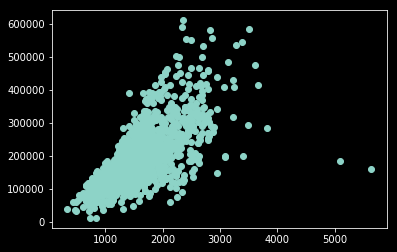

In [9]:
# finding outliers
plt.style.use('dark_background')
plt.scatter(x = ames['Gr Liv Area'], y = ames['SalePrice'])

In [10]:
# drop the two outliers
ames.drop([960, 1885], inplace = True)

In [11]:
# checking data types
ames.dtypes.sort_values().head()

Id                 int64
2nd Flr SF         int64
Low Qual Fin SF    int64
Gr Liv Area        int64
Full Bath          int64
dtype: object

### 4. Handling Null Values <a name="handling-nulls"></a>

In [12]:
# checking for null values - on initial analysis there are null values in 26 columns
ames.isnull().sum().sort_values(ascending = False).head(27) 

Pool QC           2041
Misc Feature      1985
Alley             1909
Fence             1649
Fireplace Qu      1000
Lot Frontage       330
Garage Finish      114
Garage Cond        114
Garage Qual        114
Garage Yr Blt      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
BsmtFin Type 1      55
Bsmt Cond           55
Bsmt Qual           55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
Garage Area          1
Bsmt Unf SF          1
BsmtFin SF 2         1
Total Bsmt SF        1
BsmtFin SF 1         1
Overall Cond         0
dtype: int64

In [13]:
#### Looking at NaN columns, Noticing a lot of these features are objects that have 'NA' when the house #doesn't have them, pandas is interpreting this as 'NaN'
#Pool QC           2042 - Pool quality, str
#Misc Feature      1986 - Miscellaneous features ex tennis courts, elevators, str
#Alley             1911 - type of alley accss to property, str
#Fence             1651 - fence quality (privacy), str
#Fireplace Qu      1000 - Fireplace quality, str
#Lot Frontage       330 - **num - linear feet of street connected to property, change to 0**
#Garage Finish      114 - finish quality of garage (finished or not), str
#Garage Cond        114 - garage condition, str
#Garage Qual        114 - **garage quality (same as garage condition?), str, DROP**
#Garage Yr Blt      114 - **num - year garage built, DROP**
#Garage Type        113 - garage location (attached, etc), str
#Bsmt Exposure       58 - basement walkout level, str 
#BsmtFin Type 2      56 - rating of basement finish type, str
#BsmtFin Type 1      55 - **num - basement square feet**
#Bsmt Cond           55 - condition of basement, str
#Bsmt Qual           55 - height of the basement, str
#Mas Vnr Type        22 - masonry veneer type, str
#Mas Vnr Area        22 - **num - masonry veneer area in sqft**
#Bsmt Half Bath       2 - **int - # basement half bathrooms**
#Bsmt Full Bath       2 - **int - # basement full bathrooms**
#Garage Cars          1 - **int - number of cars garage can fit**
#Garage Area          1 - **num.- size of garage in sqft**
#Bsmt Unf SF          1 - **num - size of unfinished basement in sqft**
#BsmtFin SF 2         1 - **num - type 2 finished sqft**
#Total Bsmt SF        1 - **num - total square footage of bsmt**
#BsmtFin SF 1         1 - **num - type 1 finished sqft**

In [14]:
#Setting all nan values to 0 - for training data
ames.fillna(0, inplace = True)

# filling null vals with 0 - for test data
ames_test.fillna(0, inplace = True)

In [15]:
# columns with NaNs - all nans gone
ames.isnull().sum().sort_values(ascending=False).head()

SalePrice         0
Total Bsmt SF     0
Year Remod/Add    0
Roof Style        0
Roof Matl         0
dtype: int64

## Feature Engineering & Selection <a name="feat-eng"></a>

### 5. Mapping Numeric Values to Ordinal Ratings (Obj) <a name="mapping-ordinals"></a>

##### Training Data

In [16]:
# changing object columns with ratings - mapping numerical scales
ratings = {np.NaN: 0,
           0: 0,
           'NA': 0, 
           'Po': 1, 
           'Fa': 2, 
           'TA': 3, 
           'Gd': 4, 
           'Ex': 5}

ames['Bsmt Qual'] = ames['Bsmt Qual'].map(ratings)
ames['Bsmt Cond'] = ames['Bsmt Cond'].map(ratings)
ames['Exter Cond'] = ames['Exter Cond'].map(ratings)
ames['Exter Qual'] = ames['Exter Qual'].map(ratings)
ames['Kitchen Qual'] = ames['Kitchen Qual'].map(ratings)
ames['Garage Qual'] = ames['Garage Qual'].map(ratings)
ames['Pool QC'] = ames['Pool QC'].map(ratings)
ames['Garage Cond'] = ames['Garage Cond'].map(ratings)
ames['Fireplace Qu'] = ames['Fireplace Qu'].map(ratings)

In [17]:
# changing object columns with special ratings - mapping numeric scales
ratings_special = {np.NaN: 0,
                   'NA': 0,
                   ' ': 0,
                   'Gd': 3, 
                   'Av': 2,
                   'Mn': 1,
                   'No': 0,
                   'NA': 0,
                   'GLQ': 6,
                   'ALQ': 5,
                   'BLQ': 4,
                   'Rec': 3,
                   'LwQ': 2,
                   'Unf': 1,
                   'SBrkr': 4,
                   'FuseA': 3,
                   'FuseF': 2,
                   'FuseP': 1,
                   'Mix': 0,
                   'Typ': 7,
                  'Min1': 6,
                  'Min2': 5,
                  'Mod': 4,
                  'Maj1': 3,
                  'Maj2': 2,
                  'Sev': 1,
                  'Sal': 0,
                  'GdPrv': 4,
                  'MnPrv': 3,
                  'GdWo': 2,
                  'MnWw': 1,
                  'NA': 0,
                  'Fin': 3,
                  'RFn': 2,
                  'Unf': 1,
                  'NA': 0}

ames['Bsmt Exposure'] = ames['Bsmt Exposure'].map(ratings_special)
ames['BsmtFin Type 1'] = ames['BsmtFin Type 1'].map(ratings_special)
ames['BsmtFin Type 2'] = ames['BsmtFin Type 2'].map(ratings_special)
ames['Electrical'] = ames['Electrical'].map(ratings_special)
ames['Functional'] = ames['Functional'].map(ratings_special)
ames['Fence'] = ames['Fence'].map(ratings_special)
ames['Garage Finish'] = ames['Garage Finish'].map(ratings_special)
ames['Garage Finish'].value_counts()

1.0    849
2.0    579
3.0    507
Name: Garage Finish, dtype: int64

In [18]:
# creating columns rating the quality of exterior materials
ames['Exterior1'] = ames['Exterior 1st']
ames['Exterior2'] = ames['Exterior 2nd']

building_mats = {np.NaN: 0,
                 0: 0,
                 'NA': 0,
                 ' ': 0,
                 'AsbShng':	0,
                 'AsphShn': 1,	
                 'BrkComm': 1,
                 'BrkFace': 2,
                 'CBlock': 0,
                 'CemntBd': 0,
                 'HdBoard': 0,
                 'ImStucc': 1,
                 'MetalSd': 0,
                 'Other': 0,
                 'Plywood': 0,
                 'PreCast': 0,
                 'Stone': 2,
                 'Stucco': 2,
                 'VinylSd': 0,
                 'Wd Sdng': 1,
                 'WdShing': 1}

ames['Exterior1'] = ames['Exterior1'].map(building_mats)
ames['Exterior2'] = ames['Exterior2'].map(building_mats)

##### Testing Data

In [19]:
# mirroring the mapping of ratings in test set
ratings = {np.NaN: 0,
           0: 0,
           'NA': 0, 
           'Po': 1, 
           'Fa': 2, 
           'TA': 3, 
           'Gd': 4, 
           'Ex': 5}

ames_test['Bsmt Qual'] = ames_test['Bsmt Qual'].map(ratings)
ames_test['Bsmt Cond'] = ames_test['Bsmt Cond'].map(ratings)
ames_test['Exter Cond'] = ames_test['Exter Cond'].map(ratings)
ames_test['Exter Qual'] = ames_test['Exter Qual'].map(ratings)
ames_test['Kitchen Qual'] = ames_test['Kitchen Qual'].map(ratings)
ames_test['Garage Qual'] = ames_test['Garage Qual'].map(ratings)
ames_test['Pool QC'] = ames_test['Pool QC'].map(ratings)
ames_test['Garage Cond'] = ames_test['Garage Cond'].map(ratings)
ames_test['Fireplace Qu'] = ames_test['Fireplace Qu'].map(ratings)

In [20]:
# changing object columns with special ratings - mapping numeric scales
ratings_special = {np.NaN: 0,
                   0: 0,
                   ' ': 0,
                   'Gd': 3, 
                   'Av': 2,
                   'Mn': 1,
                   'No': 0,
                   'NA': 0,
                   'GLQ': 6,
                   'ALQ': 5,
                   'BLQ': 4,
                   'Rec': 3,
                   'LwQ': 2,
                   'Unf': 1,
                   'SBrkr': 4,
                   'FuseA': 3,
                   'FuseF': 2,
                   'FuseP': 1,
                   'Mix': 0,
                   'Typ': 7,
                  'Min1': 6,
                  'Min2': 5,
                  'Mod': 4,
                  'Maj1': 3,
                  'Maj2': 2,
                  'Sev': 1,
                  'Sal': 0,
                  'GdPrv': 4,
                  'MnPrv': 3,
                  'GdWo': 2,
                  'MnWw': 1,
                  'NA': 0,
                  'Fin': 3,
                  'RFn': 2,
                  'Unf': 1,
                  'NA': 0}

ames_test['Bsmt Exposure'] = ames_test['Bsmt Exposure'].map(ratings_special)
ames_test['BsmtFin Type 1'] = ames_test['BsmtFin Type 1'].map(ratings_special)
ames_test['BsmtFin Type 2'] = ames_test['BsmtFin Type 2'].map(ratings_special)
ames_test['Electrical'] = ames_test['Electrical'].map(ratings_special)
ames_test['Functional'] = ames_test['Functional'].map(ratings_special)
ames_test['Fence'] = ames_test['Fence'].map(ratings_special)
ames_test['Garage Finish'] = ames_test['Garage Finish'].map(ratings_special)

In [21]:
# creating columns rating the quality of exterior materials - this is guesswork so I'm going to
# keep the original columns and dummy them out b/c I'm not totally sure which mats are woth more
ames_test['Exterior1'] = ames_test['Exterior 1st']
ames_test['Exterior2'] = ames_test['Exterior 2nd']

building_mats = {'NA': 0,
                 np.NaN: 0,
                 0: 0,
                 ' ': 0,
                 'AsbShng':	0,
                 'AsphShn': 1,	
                 'BrkComm': 1,
                 'BrkFace': 2,
                 'CBlock': 0,
                 'CemntBd': 0,
                 'HdBoard': 0,
                 'ImStucc': 1,
                 'MetalSd': 0,
                 'Other': 0,
                 'Plywood': 0,
                 'PreCast': 0,
                 'Stone': 2,
                 'Stucco': 2,
                 'VinylSd': 0,
                 'Wd Sdng': 1,
                 'WdShing': 1}

ames_test['Exterior1'] = ames_test['Exterior1'].map(building_mats)
ames_test['Exterior2'] = ames_test['Exterior2'].map(building_mats)

### 6. Changing Numeric Features to Categorical <a name="numeric-to-cat"></a>

##### Training Data

In [22]:
# changing MS Subclass to object
ames = ames.astype({"MS SubClass": str})

In [23]:
# making buckets for years built: https://stackoverflow.com/questions/33850831/years-to-decades
ames = ames.astype({"Year Built": str})
ames['decade'] = (ames['Year Built'].apply(lambda x: x[:3] + '0')).astype('str')
ames['decade'].value_counts()

2000    559
1970    247
1960    245
1950    241
1990    236
1920    138
1940    112
1980     79
1930     76
1910     71
1900     25
1890     12
1880      4
1870      3
2010      1
Name: decade, dtype: int64

In [24]:
# making buckets for garage years built: https://stackoverflow.com/questions/33850831/years-to-decades
ames = ames.astype({"Garage Yr Blt": str})
ames['garage_decade'] = (ames['Garage Yr Blt'].apply(lambda x: x[:3] + '0')).astype('str')
ames['garage_decade'].value_counts() # there's one built in the 2200s???

2000    574
1990    279
1970    258
1960    245
1950    219
1980    121
0.00    114
1940     78
1930     68
1920     66
1910     19
1900      3
1890      2
2010      2
2200      1
Name: garage_decade, dtype: int64

In [25]:
# found a value that was wrong (in the future) - changed to normal val
ames.loc[1699, 'Garage Yr Blt']

'2207.0'

In [26]:
ames.loc[1699, 'Garage Yr Blt'] = 2007

##### Testing Data

In [27]:
# changing MS Subclass to object
ames_test = ames_test.astype({"MS SubClass": str})

In [28]:
# making buckets for years built: https://stackoverflow.com/questions/33850831/years-to-decades
ames_test = ames_test.astype({"Year Built": str})
ames_test['decade'] = (ames_test['Year Built'].apply(lambda x: x[:3] + '0')).astype('str')
ames_test['decade'].value_counts()

2000    219
1970    117
1960    112
1950     99
1990     98
1920     58
1980     41
1910     39
1940     39
1930     33
1900     15
1880      4
1890      3
2010      2
Name: decade, dtype: int64

In [29]:
# making buckets for garage years built: https://stackoverflow.com/questions/33850831/years-to-decades
ames_test = ames_test.astype({"Garage Yr Blt": str})
ames_test['garage_decade'] = (ames_test['Garage Yr Blt'].apply(lambda x: x[:3] + '0')).astype('str')
ames_test['garage_decade'].value_counts()

2000    226
1960    116
1990    112
1970    112
1950    102
1980     58
0.00     45
1920     38
1930     25
1940     25
1910     12
1900      5
2010      3
Name: garage_decade, dtype: int64

### 7. Creating New Numeric Features <a name="new-feat"></a>

##### Training Data

In [30]:
# new columns for all baths
ames['Total_Bath'] = ames['Full Bath'] + 0.5*(ames['Half Bath'])
ames['Bsmt_Bath'] = ames['Bsmt Full Bath'] + 0.5*(ames['Bsmt Half Bath'])

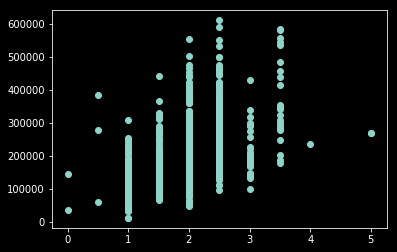

In [31]:
# plotting total baths against saleprice - looks like there is a linear relationship
plt.scatter(ames['Total_Bath'], ames['SalePrice'])

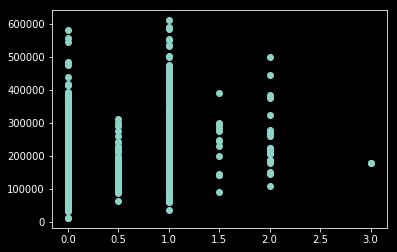

In [32]:
# basement bathrooms aren't quite as important as above-ground bathrooms
plt.scatter(ames['Bsmt_Bath'], ames['SalePrice'])

In [33]:
# yr and month sold combo to create actual timeframe
ames['sell_time'] = ames['Yr Sold'] + ((ames['Mo Sold'] -1)/12)
ames['sell_time'].sort_values(ascending=False).tail()

741     2006.0
880     2006.0
24      2006.0
1093    2006.0
1713    2006.0
Name: sell_time, dtype: float64

In [34]:
# new feature to calculate time since the house was last remodeled 
ames['since_remodel'] = ames['sell_time'] - ames['Year Remod/Add']
ames['since_remodel'].head()

0     5.166667
1    12.250000
2     3.000000
3     3.250000
4    17.166667
Name: since_remodel, dtype: float64

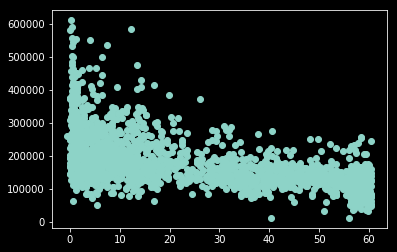

In [35]:
# seems houses remodeled more recently are selling for more
plt.scatter(ames['since_remodel'], ames['SalePrice'])

##### Testing Data

In [36]:
# new columns for all baths
ames_test['Total_Bath'] = ames_test['Full Bath'] + 0.5*(ames_test['Half Bath'])
ames_test['Bsmt_Bath'] = ames_test['Bsmt Full Bath'] + 0.5*(ames_test['Bsmt Half Bath'])

In [37]:
# yr and month sold combo
ames_test['sell_time'] = ames_test['Yr Sold'] + ((ames['Mo Sold'] -1)/12)
ames_test['sell_time'].head()

0    2006.166667
1    2006.250000
2    2006.000000
3    2007.250000
4    2009.166667
Name: sell_time, dtype: float64

In [38]:
ames_test['since_remodel'] = ames_test['sell_time'] - ames_test['Year Remod/Add']
ames_test['since_remodel'].head()

0    56.166667
1    29.250000
2     0.000000
3     1.250000
4    46.166667
Name: since_remodel, dtype: float64

### 8. Checking New Columns <a name="check-new"></a>

In [39]:
# filling any more nulls
ames.fillna(0, inplace = True)
ames_test.fillna(0, inplace=True)

In [40]:
# setting up df just for numeric data
numer_feat = ames._get_numeric_data()
numer_feat.head()

,Id,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Mo Sold,Yr Sold,SalePrice,Exterior1,Exterior2,Total_Bath,Bsmt_Bath,sell_time,since_remodel
0,109,533352170,0.0,13517,6,8,2005,289.0,4,3,3,3,0.0,6.0,533.0,1.0,0.0,192.0,725.0,4,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,7,0,0,2.0,2.0,475.0,3,3,0,44,0,0,0,0,0,0.0,0,3,2010,130500,0,0.0,2.5,0.0,2010.166667,5.166667
1,544,531379050,43.0,11492,7,5,1997,132.0,4,3,4,3,0.0,6.0,637.0,1.0,0.0,276.0,913.0,4,913,1209,0,2122,1.0,0.0,2,1,4,1,4,8,7,1,3,2.0,2.0,559.0,3,3,0,74,0,0,0,0,0,0.0,0,4,2009,220000,0,0.0,2.5,1.0,2009.250000,12.250000
2,153,535304180,68.0,7922,5,7,2007,0.0,3,4,3,3,0.0,6.0,731.0,1.0,0.0,326.0,1057.0,4,1057,0,0,1057,1.0,0.0,1,0,3,1,4,5,7,0,0,1.0,1.0,246.0,3,3,0,52,0,0,0,0,0,0.0,0,1,2010,109000,0,0.0,1.0,1.0,2010.000000,3.000000
3,318,916386060,73.0,9802,5,5,2007,0.0,3,3,4,3,0.0,1.0,0.0,1.0,0.0,384.0,384.0,4,744,700,0,1444,0.0,0.0,2,1,3,1,3,7,7,0,0,3.0,2.0,400.0,3,3,100,0,0,0,0,0,0,0.0,0,4,2010,174000,0,0.0,2.5,0.0,2010.250000,3.250000
4,255,906425045,82.0,14235,6,8,1993,0.0,3,3,2,4,0.0,1.0,0.0,1.0,0.0,676.0,676.0,4,831,614,0,1445,0.0,0.0,2,0,3,1,3,6,7,0,0,1.0,2.0,484.0,3,3,0,59,0,0,0,0,0,0.0,0,3,2010,138500,1,0.0,2.0,0.0,2010.166667,17.166667


In [41]:
# setting list of numeric cols
numer_cols = list(numer_feat.columns)

In [42]:
# separating out object columns
obj_cols = []
for x in ames.columns:
    if x not in numer_cols:
        obj_cols.append(x)

In [43]:
obj_cols.remove('Garage Yr Blt') # made into garage decade
obj_cols.remove('Year Built') # made into year built decade

In [44]:
numer_cols.remove('PID') # won't be modeling with this
numer_cols.remove('Full Bath') # covered in total baths
numer_cols.remove('Half Bath') # covered in total baths
numer_cols.remove('Yr Sold') # covered in 'sell_time'
numer_cols.remove('Mo Sold') # covered in 'sell_time'
numer_cols.remove('Bsmt Full Bath') # covered in bsmt baths
numer_cols.remove('Bsmt Half Bath') # covered in bsmt baths
numer_cols.remove('Year Remod/Add') # same thing as 'since_remodel'
numer_cols.remove('SalePrice') # target

### 9. Initial Correlations Analysis <a name="init-corr"></a>

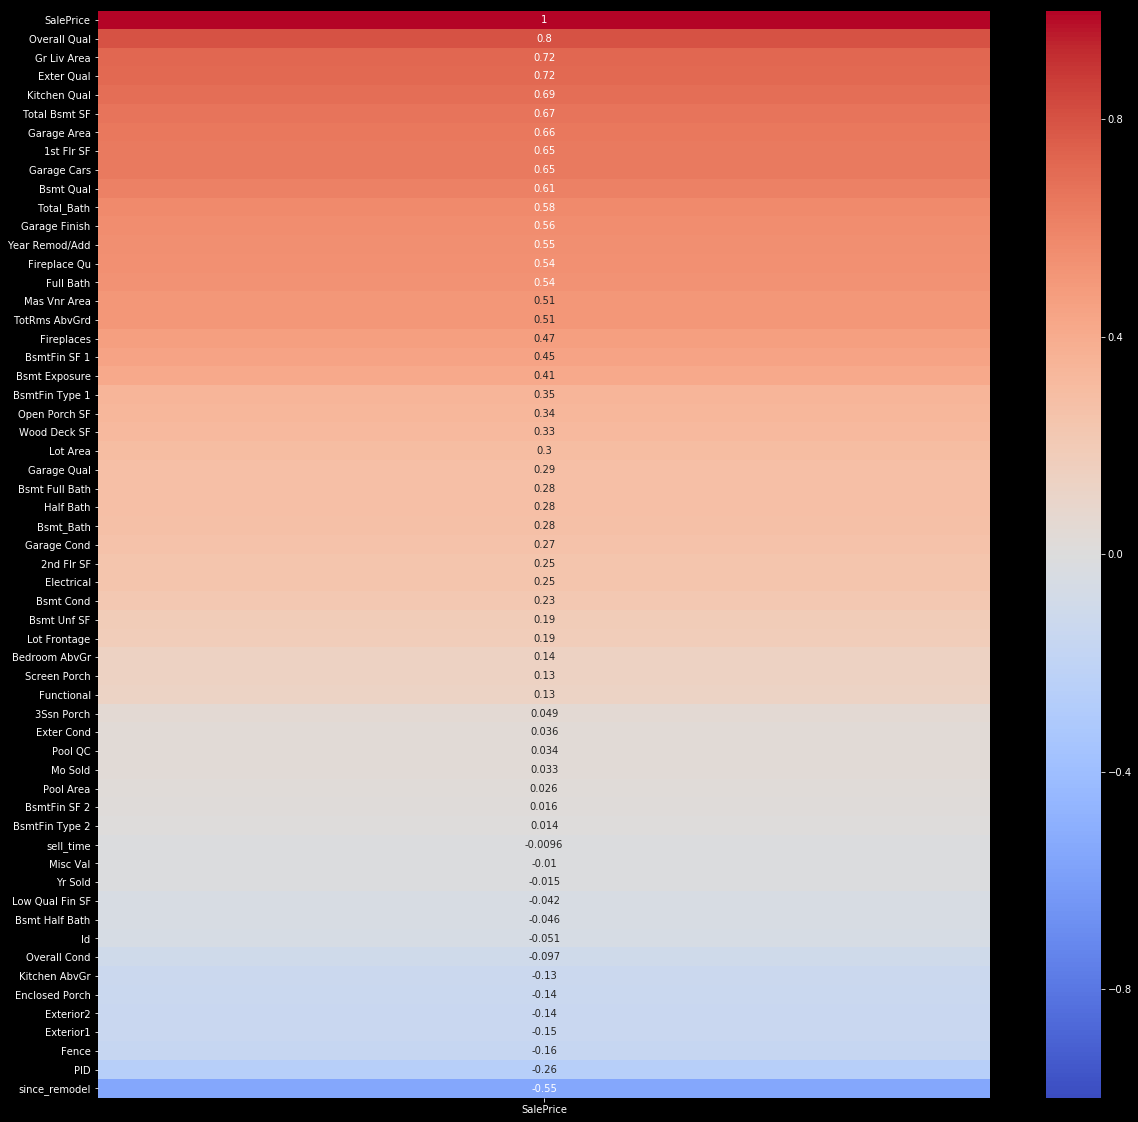

In [45]:
# heatmap
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20, 20))
plt.fontsize = 20
sns.heatmap(ames.corr()[['SalePrice']].sort_values("SalePrice", ascending = False), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1);

(array([ 42., 525., 816., 350., 168.,  79.,  40.,  16.,   6.,   7.]),
 array([ 12789. ,  72675.8, 132562.6, 192449.4, 252336.2, 312223. ,
        372109.8, 431996.6, 491883.4, 551770.2, 611657. ]),
 <a list of 10 Patch objects>)

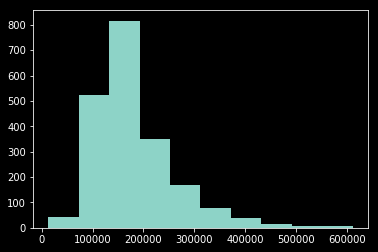

In [46]:
# seeing a positive skew in our saleprice data
plt.hist(ames['SalePrice'])

In [47]:
ames.shape # shape before dummy/poly features

(2049, 89)

### 10. Dummying Categorical Variables & New Cat Vars <a name="dummy-var"></a>

##### Training Data

In [48]:
# creating dummy column for asbestos, curious if this impacts price
ames['asbestos'] = np.where(((ames['Exterior 1st'] == 'AsbShng') | 
                           (ames['Exterior 2nd'] == 'AsbShng')), 1, 0)
ames['asbestos'].value_counts()

0    2013
1      36
Name: asbestos, dtype: int64

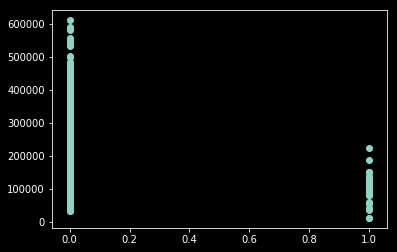

In [49]:
# it looks like there is a value cap on houses with asbestos in housing materials
plt.scatter(ames['asbestos'], ames['SalePrice']) 

In [50]:
# Setting up mansion variable, just guessing here.
ames['mansion'] = np.where(((ames['Fireplaces'] > 1) | 
                            (ames['Kitchen AbvGr'] > 1) | 
                            (ames['TotRms AbvGrd'] > 10) |
                           (ames['Bedroom AbvGr'] > 5)), 1, 0)
ames['mansion'].value_counts()

0    1798
1     251
Name: mansion, dtype: int64

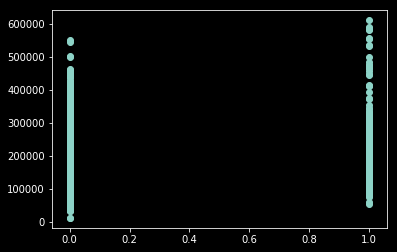

In [51]:
# plotting this, doesn't look like it's very relevant
plt.scatter(ames['mansion'], ames['SalePrice'])

In [52]:
# dropping mansion
ames.drop(columns=['mansion'], inplace=True)

In [53]:
# setting dummy vars, just the object columns
ames = pd.get_dummies(ames, columns=obj_cols, drop_first = True)

##### Testing Data

In [54]:
# creating dummy column for asbestos
ames_test['asbestos'] = np.where(((ames_test['Exterior 1st'] == 'AsbShng') | 
                           (ames_test['Exterior 2nd'] == 'AsbShng')), 1, 0)
ames_test['asbestos'].value_counts()

0    868
1     11
Name: asbestos, dtype: int64

In [55]:
# creating dummy vars for test set, same as train
ames_test = pd.get_dummies(ames_test, columns=obj_cols, drop_first = True)

##### Fixing Columns Mismatch

In [56]:
# finding missing columns from train set
missing_cols = set(ames.columns) - set(ames_test.columns)

# for missing columns, setting this to 0 for test
for c in missing_cols:
    ames_test[c] = 0
    
# setting order of ames_test columns to same as train
ames_test = ames_test[ames.columns]

# checking ames test shape
ames_test.shape

(879, 255)

In [57]:
# Dropping empty saleprice column
ames_test.drop(columns = ['SalePrice'], inplace = True)

In [58]:
ames.shape

(2049, 255)

In [59]:
ames_test.shape

(879, 254)

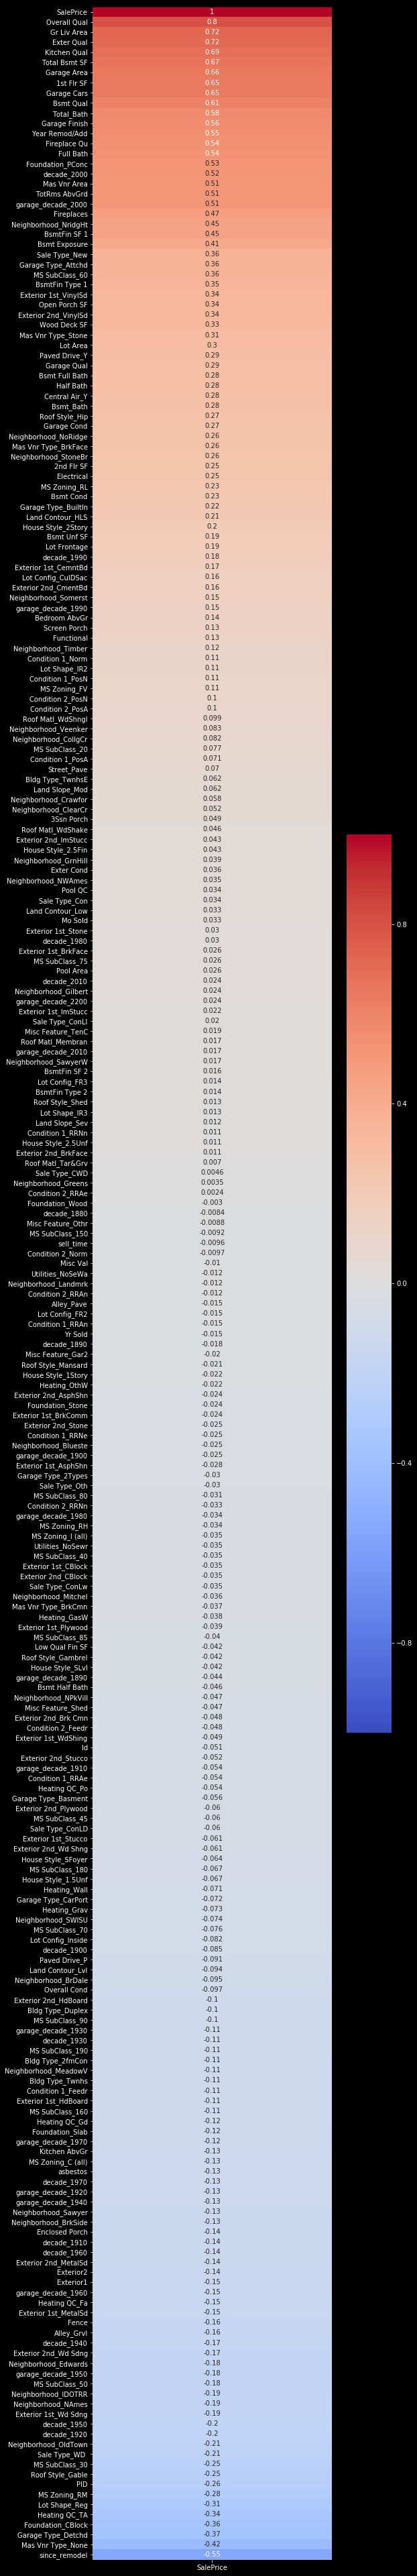

In [60]:
# heatmap again with dummy vars
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(8, 70))
plt.fontsize = 20
sns.heatmap(ames.corr()[['SalePrice']].sort_values("SalePrice", ascending = False), annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1);

### 11. Initial Variable Selection & Train/Test/Split <a name="train-test"></a>

In [61]:
features = ames.drop(columns=['Id', 'PID', 'Full Bath', 'Half Bath', 'Yr Sold', 'Mo Sold',
                              'Bsmt Full Bath', 'Bsmt Half Bath', 'Year Remod/Add', 'SalePrice',
                              'Year Built', 'Garage Yr Blt']).columns

In [62]:
X = ames[features]
y = ames['SalePrice']

In [97]:
X.shape

(2049, 243)

In [98]:
y.shape

(2049,)

##### Normalizing y

In [63]:
# taking log of y - this is something we can reverse later, will normalize the prices
y_log = ames['SalePrice'].map(np.log)

In [99]:
y_log.shape

(2049,)

##### Setting up X for test set

In [64]:
# setting X for test set
features_test = ames.drop(columns=['Id', 'PID', 'Full Bath', 'Half Bath', 'Yr Sold', 'Mo Sold',
                              'Bsmt Full Bath', 'Bsmt Half Bath', 'Year Remod/Add',
                              'Year Built', 'Garage Yr Blt']).columns
X_truetest = ames_test[features]

##### Train/Test/Split for X

In [65]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state = 42)

# log tricks
#y_train_log = np.log(y_train)
#y_test_log = np.log(y_test)

##### Testing Initial Linear Regression

In [66]:
# fitting linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
# scoring our training set - looks like a lot of variation in the scores
cv_scores = cross_val_score(lr, X_train, y_train)
cv_scores

array([0.89750283, 0.88379293, 0.87340346])

In [68]:
# scoring on test set - performing much better and more consistently. 
cv_scores = cross_val_score(lr, X_test, y_test)
cv_scores

array([0.08217945, 0.70555984, 0.72639379])

### 12. Scaling & Setting Polynomial Features <a name="scale-poly"></a>

##### Training Data

In [69]:
# creating polynomial vars + scaled vars, transforming X to create new x
poly = PolynomialFeatures(include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [70]:
# scaling polynomial features
ss = StandardScaler()
X_train_poly = ss.fit_transform(X_train_poly)
X_test_poly = ss.transform(X_test_poly)

In [71]:
# making them into a df again
poly_col_names = poly.get_feature_names(features)
X_train_poly = pd.DataFrame(X_train_poly, columns=poly_col_names)
X_test_poly = pd.DataFrame(X_test_poly, columns=poly_col_names)

In [72]:
X_train_poly.shape

(1536, 29646)

In [73]:
X_test_poly.shape

(513, 29646)

##### Test Data

In [136]:
# setting poly
poly = PolynomialFeatures(include_bias=False)
X_truetest_poly = poly.fit_transform(X_truetest)

# scaling all 
ss = StandardScaler()
X_truetest_poly = ss.fit_transform(X_truetest_poly)

# getting poly names and creating df poly version
poly_col_names_t = poly.get_feature_names(features)
X_truetest_poly = pd.DataFrame(X_truetest_poly, columns=poly_col_names_t)
X_truetest_poly.shape

(879, 29889)

## Modeling <a name="modeling"></a>

### 13. Linear Regression Modeling <a name="lr"></a>

In [75]:
# fitting model to X polynomial features, salesprice
lr = LinearRegression()
lr.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [76]:
# scoring training
cv_scores = cross_val_score(lr, X_train_poly, y_train)
cv_scores

array([0.86201172, 0.82226859, 0.8229011 ])

In [77]:
# scoring test
cv_scores = cross_val_score(lr, X_test_poly, y_test)
cv_scores

array([-0.87862437,  0.76402555,  0.83193739])

### 14. Lasso Modeling <a name="lasso"></a>

In [78]:
lasso_cv = LassoCV(normalize = True)
lasso_cv = lasso_cv.fit(X_train_poly, y_train)

In [79]:
# optimal alpha for lasso
lasso_opt_alpha = lasso_cv.alpha_
lasso_opt_alpha

0.00021813506928281597

In [80]:
# instantiating lasso model with ideal alpha from before
lasso = Lasso(alpha = 0.00021813506928281597, normalize = True)
lasso_mod = lasso.fit(X_train_poly, y_train)

In [81]:
# scoring lasso on train 
cv_scores = cross_val_score(lasso_mod, X_train_poly, y_train)
cv_scores

array([0.92274756, 0.89555454, 0.90310913])

(array([  2.,   1.,  11.,  23., 130., 569., 620., 157.,  18.,   5.]),
 array([-0.62728428, -0.52321047, -0.41913665, -0.31506284, -0.21098903,
        -0.10691521, -0.0028414 ,  0.10123241,  0.20530622,  0.30938004,
         0.41345385]),
 <a list of 10 Patch objects>)

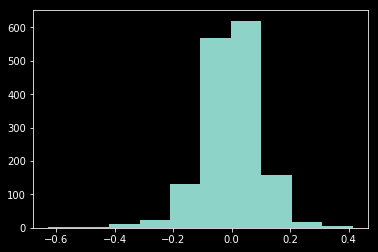

In [82]:
# pretty normal dist. in residuals
lasso_preds = lasso_mod.predict(X_train_poly)
lasso_resids = y_train - lasso_preds
plt.hist(lasso_resids)

In [83]:
# scoring lasso on test
cv_scores = cross_val_score(lasso_mod, X_test_poly, y_test)
cv_scores

array([0.88247196, 0.83603178, 0.83749139])

In [84]:
# Getting lasso features
coef_cols = pd.DataFrame(list(zip(lasso_mod.coef_, X_test_poly)))
coef_cols.columns = ['coeffs', 'features']

In [88]:
coef_over_0 = coef_cols[abs(coef_cols['coeffs'] >= 0.001)]
coef_over_0.sort_values(by='coeffs', ascending=False).head(10)

,coeffs,features
4897,0.073024,Gr Liv Area Functional
769,0.035530,Overall Qual sell_time
793,0.029392,Overall Qual Street_Pave
1923,0.029339,Bsmt Qual Total Bsmt SF
1457,0.028084,Exter Qual Gr Liv Area
2618,0.021276,BsmtFin Type 1 BsmtFin SF 1
6856,0.019672,Garage Cars Garage Qual
490,0.017484,Lot Area Bsmt Qual
979,0.013905,Overall Cond 1st Flr SF
5734,0.013547,Kitchen Qual Paved Drive_Y


##### Fitting model on whole X

In [129]:
# setting poly
poly = PolynomialFeatures(include_bias=False)
X_new = poly.fit_transform(X)

In [130]:
# scaling all 
ss = StandardScaler()
X_new = ss.fit_transform(X_new)

In [131]:
# getting poly names and creating df poly version
poly_col_names_t = poly.get_feature_names(features)
X_new = pd.DataFrame(X_new, columns=poly_col_names_t)
X_new.shape

(2049, 29889)

In [96]:
y_log.shape

(2049,)

In [117]:
lasso_cv = LassoCV(normalize = True)
lasso_cv = lasso_cv.fit(X_new, y_log)

In [118]:
# optimal alpha for lasso
lasso_opt_alpha = lasso_cv.alpha_
lasso_opt_alpha

0.00024955722754911364

In [119]:
#refitting on whole X
lasso = Lasso(alpha = 0.00024955722754911364, normalize = True)
lasso_mod2 = lasso.fit(X_new, y_log)

In [120]:
# scoring lasso on all
cv_scores = cross_val_score(lasso_mod2, X_new, y_log)
cv_scores

array([0.88575324, 0.9274003 , 0.85873686])

### 15. Elastic Net Modeling  <a name="elastic-net"></a>

In [132]:
# Set up a list of alphas to check.
enet_alphas = np.arange(0.000000001, 1.0, 0.001)

# Set up our l1 ratio.
enet_ratio = 0.9

# Instantiate model.
enet_model = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=3)

# Fit model using optimal alpha.
enet_model = enet_model.fit(X_new, y_log)

In [133]:
# optimal alpha for lasso
enet_opt_alpha = enet_model.alpha_
enet_opt_alpha

0.0050000010000000004

## Making Predictions <a name="preds"></a>

In [137]:
log_y = enet_model.predict(X_truetest_poly)

In [138]:
X_truetest_poly.shape

(879, 29889)

##### Reversing Log of y

In [139]:
pred = np.exp(log_y)

In [109]:
pred.shape

(879,)

#### Setting SalePrice Column in Test Set

In [140]:
# set new column = preds
ames_test['SalePrice'] = pred

In [111]:
# checking new df shape, match
ames_test.shape

(879, 255)

In [112]:
# checking df
ames_test.head()

,Id,PID,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Mo Sold,Yr Sold,Exterior1,Exterior2,Total_Bath,Bsmt_Bath,sell_time,since_remodel,asbestos,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Pave,Alley_Grvl,Alley_Pave,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Mod,Land Slope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_GrnHill,Neighborhood_IDOTRR,Neighborhood_Landmrk,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_Membran,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stone,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_Y,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Paved Drive_P,Paved Drive_Y,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,decade_1880,decade_1890,decade_1900,decade_1910,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010,garage_decade_1890,garage_decade_1900,garage_decade_1910,garage_decade_1920,garage_decade_1930,garage_decade_1940,garage_decade_1950,garage_decade_1960,garage_decade_1970,garage_decade_1980,

##### Setting Kaggle Export

In [141]:
# Setting new df = 2 cols
ames_test_kaggle12 = ames_test[['Id', 'SalePrice']]

In [114]:
# checking shape
ames_test_kaggle12.shape

(879, 2)

In [127]:
ames_test_kaggle11.head()

,Id,SalePrice
0,2658,112808.838754
1,2718,171229.112167
2,2414,211854.135273
3,1989,108989.586273
4,625,175411.117103


In [142]:
# Exporting to Kaggle
ames_test_kaggle12.to_csv('./datasets/kagglev12', index = False)

## Final Thoughts <a name="final"></a>


This was an interesting challenge and good first foray into linear regression modeling with python, pandas, and sklearn. If I were to try this again, I would have started using GridSearch earlier on to help with model selection and tuning parameters, and spend more time looking at the features and trying to build a simpler model. I also would have spent more time on EDA and data cleaning - there were different decisions I could have made regarding how to deal with missing numerical information (ex. lot frontage) and it would have been interesting to see how that may have made a difference on the model predictions. I would have liked to test my hypothesis on converting ordinal values again against dummying out those variables to see if it did make a difference with my final model. 

Finally, being able to translate what my model says about the true predictors of housing price is important and combination features/polynomial features are difficult to interpret, so I could have gone back and tried a simpler model to get clearer coefficients for those individual features (ex. overall quality, total above grade living area). 